## Prepare Packages

In [10]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward


cuda is available


## Import model (Policy and TiDE)

In [11]:
from policy import PolicyNN
model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model.load_state_dict(torch.load("policy_model_0702_allloss_3L_1024H_s1_c0.pth", map_location="cpu"))
# model.load_state_dict(torch.load("policy_model_0630_onlytracking_3L_1024H.pth", map_location="cpu"))

<All keys matched successfully>

In [17]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())



## Run Initial Gamma

In [27]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 #50 

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

print("init_avg shape:", init_avg.shape)

mins, _ = init_avg.min(dim=1)  
maxs, _ = init_avg.max(dim=1)  

for i, (mn, mx) in enumerate(zip(mins, maxs), start=1):
    print(f"Element {i}: min = {mn.item()}, max = {mx.item()}")

100%|██████████| 250/250 [00:08<00:00, 30.26it/s]

init_avg shape: torch.Size([2, 50])
Element 1: min = 400.0, max = 2479.916748046875
Element 2: min = -0.5510203838348389, max = 0.0


## Import reference data

In [ ]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)

# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)

# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

In [14]:
print("laser_power_ref shape:", laser_power_ref.size())
print("laser_power_ref min:", torch.min(laser_power_ref).item())
print("laser_power_ref max:", torch.max(laser_power_ref).item())

print("fix_covariates shape:", fix_covariates.size())

col_min = torch.min(fix_covariates, dim=0).values
col_max = torch.max(fix_covariates, dim=0).values

print("fix_covariates column-wise min:", col_min.cpu().numpy())
print("fix_covariates column-wise max:", col_max.cpu().numpy())

nan_indices = torch.nonzero(torch.isnan(mp_temp_ref), as_tuple=True)[0]
print("NaN indices:", nan_indices)

valid_values = mp_temp_ref[~torch.isnan(mp_temp_ref)]

print("mp_temp_ref (valid) min:", valid_values.min().item())
print("mp_temp_ref (valid) max:", valid_values.max().item())



laser_power_ref shape: torch.Size([6295, 1])
laser_power_ref min: 531.5235595703125
laser_power_ref max: 600.7783203125
fix_covariates shape: torch.Size([6295, 3])
fix_covariates column-wise min: [0.   0.75 0.75]
fix_covariates column-wise max: [ 7.5 20.  20. ]
NaN indices: tensor([6292, 6294])
mp_temp_ref (valid) min: 436.1014099121094
mp_temp_ref (valid) max: 3834.751220703125


In [15]:
import torch

# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)


In [16]:
def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected


In [18]:
ref_temp_t = torch.tensor(mp_temp_ref, dtype=torch.float32, device=device).reshape(-1, 1)
ref_temp_s = normalize_y(ref_temp_t, dim_id=[0]).squeeze(1)

depth_const = torch.tensor([[0.4126, 0.1423]], dtype=torch.float32, device=device)
depth_const_s = normalize_y(depth_const, dim_id=[1])
upper_line = depth_const_s[0, 0].item()
lower_line = depth_const_s[0, 1].item()

In [19]:
def run_one_step_policy_TiDE(policy_model, TiDE_model, state, P, window):
    # Reference trajectory for temperature (normalized)
    mp_temp_ref = state["ref"][state["MPC_counter"]:state["MPC_counter"] + P]
    mp_temp_ref_s = torch.as_tensor(mp_temp_ref, dtype=torch.float32, device=device).reshape(1, P, 1)

    # Past input (normalized)
    mp_temp_past_t = state["x_past"].T.unsqueeze(0).to(device)  # [1, window, 2]
    laser_past_t = state["u_past"].view(1, -1, 1).to(device)
    fix_cov_past = state["fix_cov_all"][state["MPC_counter"] - window:state["MPC_counter"]]
    fix_cov_past_t = torch.tensor(fix_cov_past, dtype=torch.float32, device=device).unsqueeze(0)

    mp_temp_past_s = normalize_y(mp_temp_past_t, dim_id=[0, 1])
    laser_past_s = normalize_x(laser_past_t, dim_id=[3])
    fix_cov_past_s = normalize_x(fix_cov_past_t, dim_id=[0, 1, 2])
    policy_in_past = torch.cat((fix_cov_past_s, laser_past_s, mp_temp_past_s), dim=2)  # [1, window, 6]

    # Future input (normalized)
    fix_cov_future = state["fix_cov_all"][state["MPC_counter"]:state["MPC_counter"] + P]
    fix_cov_future_t = torch.tensor(fix_cov_future, dtype=torch.float32, device=device).unsqueeze(0)
    fix_cov_future_s = normalize_x(fix_cov_future_t, dim_id=[0, 1, 2])

    depth_upper_const = 0.4126
    depth_lower_const = 0.1423
    y_const_t = torch.tensor([[depth_upper_const, depth_lower_const]] * P, dtype=torch.float32, device=device).reshape(1, P, 2)
    y_const_s = normalize_y(y_const_t, dim_id=[1])

    policy_in_future = torch.cat((fix_cov_future_s, mp_temp_ref_s, y_const_s), dim=2)  # [1, P, 6]

    # Policy inference
    u_pred = policy_model((policy_in_past, policy_in_future))  # [1, P, 1]
    u_first = u_pred[:, 0:1, :]  # [1, 1, 1]

    # Construct future covariates (rolling window with new control input)
    fix_cov_future_next = fix_cov_future_s[:, 1:, :]        # [1, P-1, 3]
    u_future_next = u_pred[:, 1:, :]                        # [1, P-1, 1]
    x_future_tide_rest = torch.cat((fix_cov_future_next, u_future_next), dim=2)  # [1, P-1, 4]

    fix_cov_last = fix_cov_future_s[:, -1:, :]              # [1, 1, 3]
    x_future_tide_last = torch.cat((fix_cov_last, u_first), dim=2)  # [1, 1, 4]

    x_future_tide = torch.cat((x_future_tide_rest, x_future_tide_last), dim=1)  # [1, P, 4]
    past_cov = torch.cat((mp_temp_past_s, fix_cov_past_s), dim=2)  # [1, window, 5]

    # TiDE prediction (normalized temp/depth with quantiles)
    tide_pred = TiDE_model((past_cov, x_future_tide, None))  # [1, P, 2, 3]
    x_current_norm = tide_pred[0, 0, 0, 1].item()  # temp, median
    depth_current_norm = tide_pred[0, 0, 1, 1].item()  # depth, median

    # Update state
    state["x_past"][:, :-1] = state["x_past"][:, 1:]
    state["x_past"][0, -1] = x_current_norm
    state["x_past"][1, -1] = depth_current_norm

    state["u_past"][:-1] = state["u_past"][1:].clone()
    state["u_past"][-1] = u_first.item()

    state["x_hat_current"] = torch.tensor([x_current_norm, depth_current_norm], device=device)
    state["x_sys_current"] = torch.tensor([[x_current_norm], [depth_current_norm]], device=device)
    state["MPC_counter"] += 1

    new_state = torch.tensor([[x_current_norm, depth_current_norm]], device=state["x_past_save"].device)
    state["x_past_save"] = torch.cat((state["x_past_save"], new_state), dim=0)

    new_u = torch.tensor([[u_first.item()]], device=state["u_past_save"].device)
    state["u_past_save"] = torch.cat((state["u_past_save"], new_u), dim=0)


In [20]:
def plot_fig(state, N_step, upper_line, lower_line):
    import matplotlib.pyplot as plt

    plt.figure(figsize=[8, 6])

    # Temp vs reference
    plt.subplot(3, 1, 1)
    plt.plot(state["x_past_save"][:N_step, 0].cpu(), label="TiDE simulation (temp)")
    plt.plot(state["ref"][:N_step], label="Reference (normalized)")
    plt.ylabel("Temp (normalized)")
    plt.legend()

    # Depth
    plt.subplot(3, 1, 2)
    plt.plot(state["x_past_save"][:N_step, 1].cpu(), label="TiDE simulation (depth)")
    plt.axhline(upper_line, linestyle="--", color="r", label="depth upper (normalized)")
    plt.axhline(lower_line, linestyle="--", color="b", label="depth lower (normalized)")
    plt.ylabel("Depth (normalized)")
    plt.legend()

    # Laser power
    plt.subplot(3, 1, 3)
    plt.plot(state["u_past_save"][:N_step].cpu(), label="Laser power (normalized)")
    plt.ylabel("Power (normalized)")
    plt.legend()

    plt.xlabel("Timestep")
    plt.tight_layout()
    plt.show()


In [21]:
def run_policy_simulation_TiDE(state, policy_model, TiDE_model, P, window, horizon):
    for step in range(horizon):
        run_one_step_policy_TiDE(policy_model, TiDE_model, state, P, window)
        if step % 100 == 0:
            print(f"Step {step}/{horizon} complete")
    print("Simulation done")


  0%|          | 0/6245 [00:00<?, ?it/s]

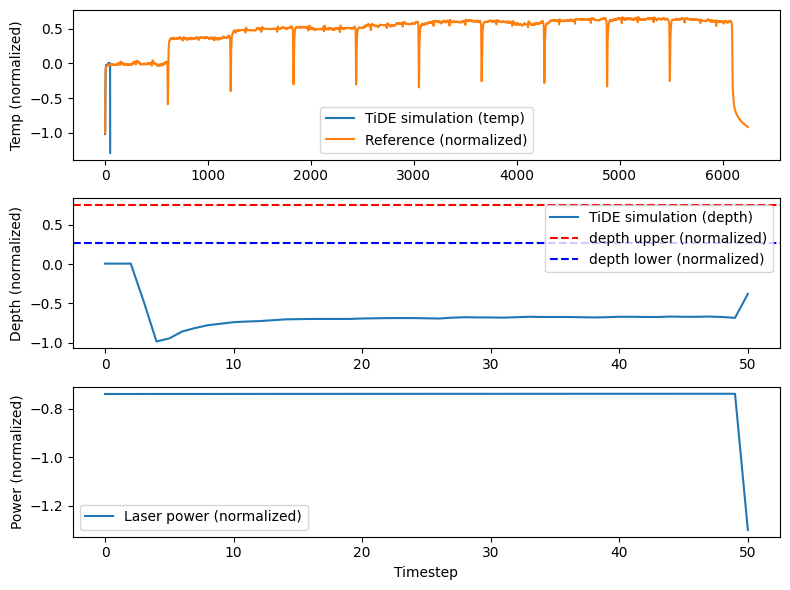

 15%|█▌        | 967/6245 [00:02<00:13, 402.75it/s]

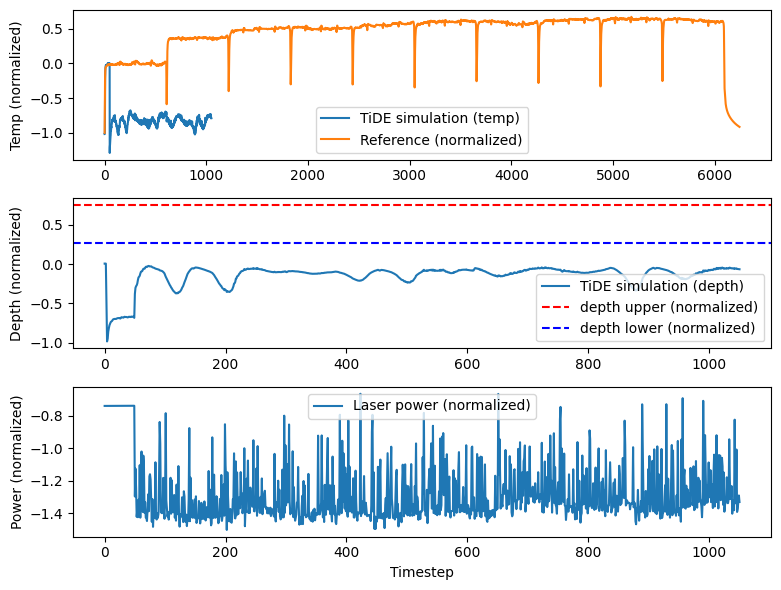

 32%|███▏      | 1985/6245 [00:05<00:10, 400.15it/s]

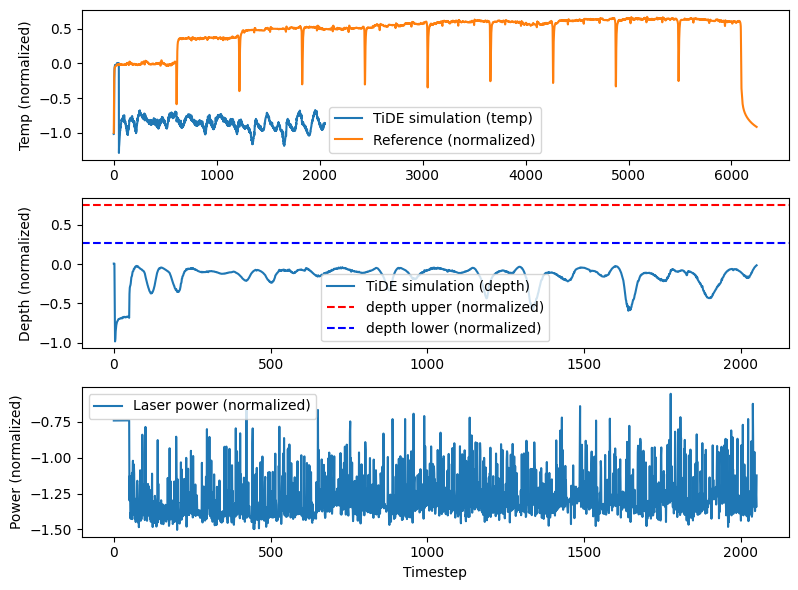

 47%|████▋     | 2965/6245 [00:08<00:08, 409.35it/s]

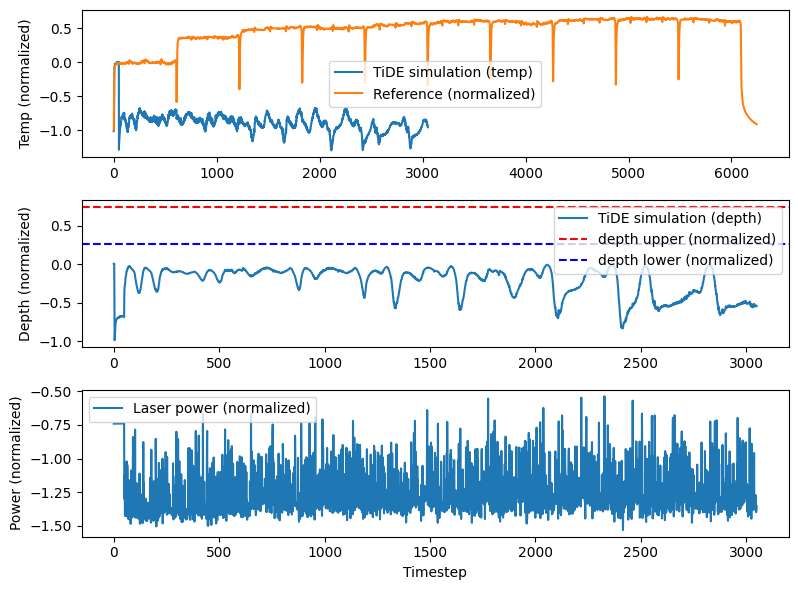

 64%|██████▍   | 3995/6245 [00:11<00:05, 386.64it/s]

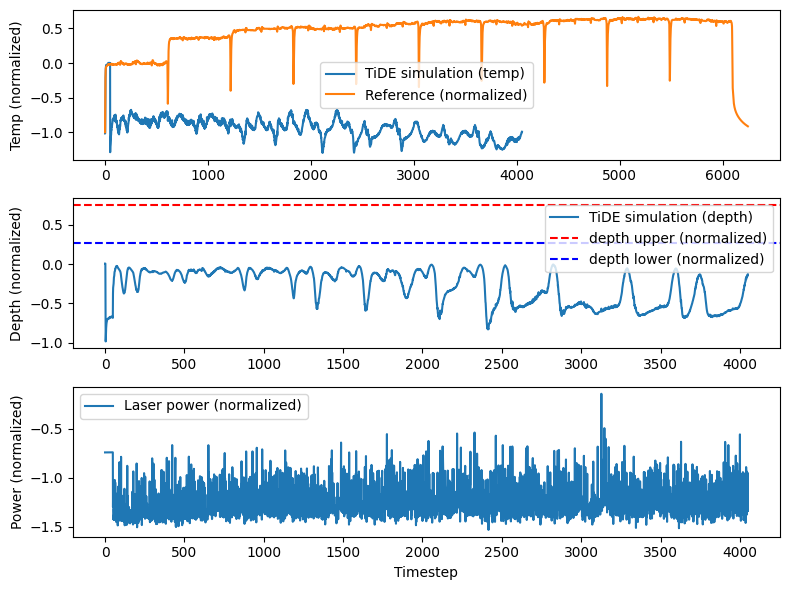

 80%|███████▉  | 4986/6245 [00:13<00:03, 381.85it/s]

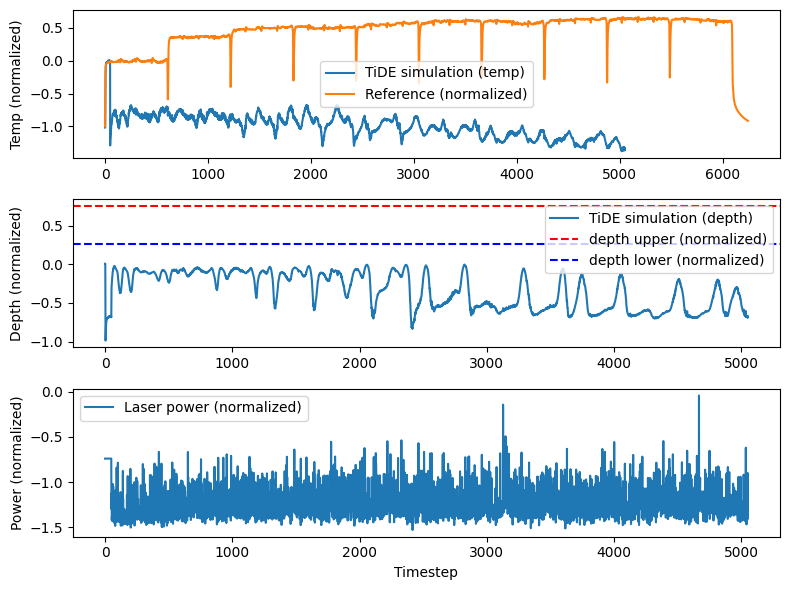

 96%|█████████▌| 5966/6245 [00:16<00:00, 404.66it/s]

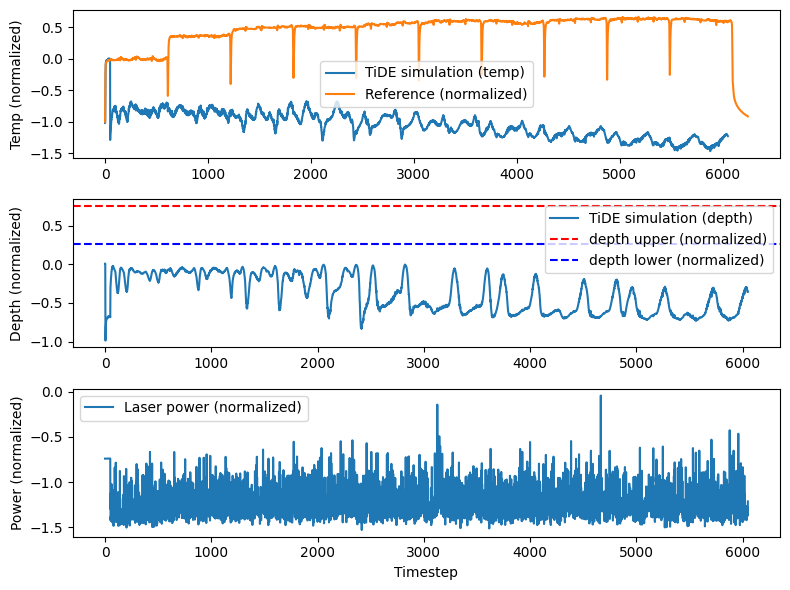

 99%|█████████▉| 6196/6245 [00:17<00:00, 353.90it/s]


RuntimeError: shape '[1, 50, 1]' is invalid for input of size 49

In [22]:
P = 50
window = 50
N_step = len(ref_temp_s) - P  # horizon

init_avg_t = torch.tensor(init_avg, dtype=torch.float32, device=device).unsqueeze(0).transpose(1, 2)  # [1, 50, 2]
init_avg_s = normalize_y(init_avg_t, dim_id=[0, 1])  
init_avg_normalized = init_avg_s.squeeze(0).T.clone()  # [2, 50]

laser_power_past_t = torch.tensor(laser_power_past, dtype=torch.float32, device=device).view(1, -1, 1)  # [1, window, 1]
laser_power_past_s = normalize_x(laser_power_past_t, dim_id=[3])  # normalize laser power
laser_power_past_normalized = laser_power_past_s.squeeze(0).squeeze(1).clone()  # [window]


state = {
    "ref": ref_temp_s.cpu().numpy(),
    "fix_cov_all": fix_covariates,
    "x_past": init_avg_normalized.clone(),  
    "u_past": laser_power_past_normalized.clone(),  
    "x_hat_current": init_avg_normalized[:, -1].clone(),
    "x_sys_current": init_avg_normalized[:, -1].reshape(2, 1).clone(),
    "x_past_save": init_avg_normalized.T.clone(),  # [window, 2]
    "u_past_save": laser_power_past_normalized.view(-1, 1).clone(),
    "MPC_counter": window
}

from tqdm import tqdm

for i in tqdm(range(N_step)):
    run_one_step_policy_TiDE(policy_model=model, TiDE_model=TiDE, state=state, P=P, window=window)

    if i % 1000 == 0:
        plot_fig(state, N_step, upper_line, lower_line)
